In [1]:
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START
from langgraph.graph.message import add_messages
from dotenv import load_dotenv
from IPython.display import Image, display
import gradio as gr
from langgraph.prebuilt import ToolNode, tools_condition
import requests
import os
from langchain.agents import Tool

from langchain_openai import ChatOpenAI
from langgraph.checkpoint.memory import MemorySaver

In [2]:
load_dotenv(override=True)

True

**Asynchronous LangGraph**

*To run a tool:*
- Sync: `tool.run(inputs)`
- Async: `await tool.arun(inputs)`

*To invoke the graph:*
- Sync: `graph.invoke(state)`
- Async: `await graph.ainvoke(state)`

In [3]:
class State(TypedDict):
    
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)

In [4]:
pushover_token = os.getenv("PUSHOVER_TOKEN")
pushover_user = os.getenv("PUSHOVER_USER")
pushover_url = "https://api.pushover.net/1/messages.json"

def push(text: str):
    """Send a push notification to the user"""
    requests.post(pushover_url, data = {"token": pushover_token, "user": pushover_user, "message": text})

tool_push = Tool(
        name="send_push_notification",
        func=push,
        description="Useful for when you want to send a push notification"
    )

In [5]:
# making sure that NodeJS is installed in this environment
!node --version

v24.4.0


Python async code only allows for one "event loop" processing aynchronous events.

The `nest_asyncio` library patches this, and is used for special situations, if you need to run a nested event loop.

In [6]:
# Introducing nest_asyncio
import nest_asyncio
nest_asyncio.apply()

In [7]:
from langchain_community.agent_toolkits import PlayWrightBrowserToolkit
from langchain_community.tools.playwright.utils import create_async_playwright_browser

# If you get a NotImplementedError here or later, see the Heads Up at the top of the notebook

async_browser =  create_async_playwright_browser(headless=False)  # headful mode
toolkit = PlayWrightBrowserToolkit.from_browser(async_browser=async_browser)
tools = toolkit.get_tools()

In [8]:
for tool in tools:
    print(f"{tool.name}={tool}")

click_element=async_browser=<Browser type=<BrowserType name=chromium executable_path=/Users/shreyashsahare28/Library/Caches/ms-playwright/chromium-1169/chrome-mac/Chromium.app/Contents/MacOS/Chromium> version=136.0.7103.25>
navigate_browser=async_browser=<Browser type=<BrowserType name=chromium executable_path=/Users/shreyashsahare28/Library/Caches/ms-playwright/chromium-1169/chrome-mac/Chromium.app/Contents/MacOS/Chromium> version=136.0.7103.25>
previous_webpage=async_browser=<Browser type=<BrowserType name=chromium executable_path=/Users/shreyashsahare28/Library/Caches/ms-playwright/chromium-1169/chrome-mac/Chromium.app/Contents/MacOS/Chromium> version=136.0.7103.25>
extract_text=async_browser=<Browser type=<BrowserType name=chromium executable_path=/Users/shreyashsahare28/Library/Caches/ms-playwright/chromium-1169/chrome-mac/Chromium.app/Contents/MacOS/Chromium> version=136.0.7103.25>
extract_hyperlinks=async_browser=<Browser type=<BrowserType name=chromium executable_path=/Users/sh

**What does PlayWright actually do?**

PlayWright allows you to launch a browser window and then the langchain tools give us a set of tools that can be used to interact with the different elements present in the browser such as *click_element*, *navigate_browser*, *previous_webpage*, etc.

In [10]:
tool_dict = {tool.name:tool for tool in tools}

navigate_tool = tool_dict.get("navigate_browser")
extract_text_tool = tool_dict.get("extract_text")

    
await navigate_tool.arun({"url": "https://www.cnn.com"})
text = await extract_text_tool.arun({})

In [11]:
import textwrap
print(textwrap.fill(text))

Breaking News, Latest News and Videos | CNN CNN values your feedback
1. How relevant is this ad to you? 2. Did you encounter any technical
issues? No Video player was slow to load content Video content never
loaded Ad froze or did not finish loading Video content did not start
after ad Audio on ad was too loud Other issues Ad never loaded Ad
prevented/slowed the page from loading Content moved around while ad
loaded Ad was repetitive to ads I've seen previously Other issues
Cancel Submit Thank You! Your effort and contribution in providing
this feedback is much
appreciated. Close Ad Feedback Close icon US World Politics Business
Health Entertainment Underscored Style Travel Sports Science Climate
Weather Ukraine-Russia War Israel-Hamas War Games More US World
Politics Business Health Entertainment Underscored Style Travel Sports
Science Climate Weather Ukraine-Russia War Israel-Hamas War Games
Watch Listen Subscribe Sign in My Account Settings Newsletters Topics
you follow Sign out You

In [12]:
all_tools = tools + [tool_push]

In [13]:
llm = ChatOpenAI(model="gpt-4o-mini")
llm_with_tools = llm.bind_tools(all_tools)


def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

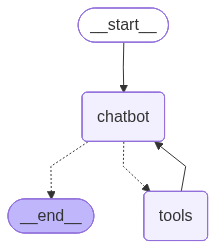

In [14]:
graph_builder = StateGraph(State)
graph_builder.add_node("chatbot", chatbot)
graph_builder.add_node("tools", ToolNode(tools=all_tools))
graph_builder.add_conditional_edges( "chatbot", tools_condition, "tools")
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")

memory = MemorySaver()
graph = graph_builder.compile(checkpointer=memory)
display(Image(graph.get_graph().draw_mermaid_png()))

In [15]:
config = {"configurable": {"thread_id": "10"}}

async def chat(user_input: str, history):
    result = await graph.ainvoke({"messages": [{"role": "user", "content": user_input}]}, config=config)
    return result["messages"][-1].content

In [16]:
gr.ChatInterface(chat, type="messages").launch()

* Running on local URL:  http://127.0.0.1:7863
* To create a public link, set `share=True` in `launch()`.
